<a href="https://colab.research.google.com/github/SaraSaponaro/SSFM_2021/blob/main/Demo2_feature_extraction_pyradiomics_lezione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting features from a segmented lesion with PyRadiomics

This demo shows how to extract intensity and shape based features form segmented masses in mammography using the [PyRadiomics](https://www.radiomics.io/pyradiomics.html) python package.
A number of mammography images and mass segmentatation masks are available in the [shared folder on Drive](https://drive.google.com/drive/folders/1YqK7ZkM-P2IrqfD7Pj-SCmjz-GWd_1-Y )

in IMAGES/Mammography_masses/


# Reading data from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip -q /content/gdrive/My\ Drive/cmepda_medphys_dataset/IMAGES/Mammography_masses/small_sample_Im_segmented_ref.zip -d /content/

dataset_path = "/content/small_sample_Im_segmented_ref"

In [5]:
!ls /content/small_sample_Im_segmented_ref

0008p1_3_1_2_mass_mask.pgm  0037p1_2_2_mass_mask.pgm
0008p1_3_1_2_resized.pgm    0037p1_2_2_resized.pgm
0016p1_2_1_mass_mask.pgm    0069p1_4_2_mass_mask.pgm
0016p1_2_1_resized.pgm	    0069p1_4_2_resized.pgm
0025p1_4_1_mass_mask.pgm    0088b1_3_1_1_mass_mask.pgm
0025p1_4_1_resized.pgm	    0088b1_3_1_1_resized.pgm
0036p1_1_1_mass_mask.pgm    0197u1_4_2_mass_mask.pgm
0036p1_1_1_resized.pgm	    0197u1_4_2_resized.pgm


# Overview of the dataset.
We use [Pillow](https://pypi.org/project/Pillow/), a Python Imaging Library which adds image processing capabilities to the Python interpreter

In [6]:
import os
import PIL

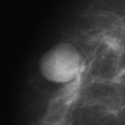

In [7]:
PIL.Image.open(os.path.join(dataset_path, "0008p1_3_1_2_resized.pgm"))

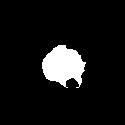

In [8]:
PIL.Image.open(os.path.join(dataset_path, "0008p1_3_1_2_mass_mask.pgm"))

# Install PyRadiomics

In [9]:
!pip install pyradiomics

     |████████████████████████████████| 194kB 6.2MB/s 
     |████████████████████████████████| 47.4MB 80kB/s 
     |████████████████████████████████| 102kB 7.9MB/s 
     |████████████████████████████████| 552kB 46.0MB/s 


# Use PyRadiomics for feature extraction

In [10]:
import os
import numpy as np
import six
from radiomics import featureextractor, getFeatureClasses
import radiomics

The feature extractor handles preprocessing, and then calls the needed featureclasses to calculate the features.

In [11]:
featureClasses = getFeatureClasses()

In [12]:
featureClasses

{'firstorder': radiomics.firstorder.RadiomicsFirstOrder,
 'glcm': radiomics.glcm.RadiomicsGLCM,
 'gldm': radiomics.gldm.RadiomicsGLDM,
 'glrlm': radiomics.glrlm.RadiomicsGLRLM,
 'glszm': radiomics.glszm.RadiomicsGLSZM,
 'ngtdm': radiomics.ngtdm.RadiomicsNGTDM,
 'shape': radiomics.shape.RadiomicsShape,
 'shape2D': radiomics.shape2D.RadiomicsShape2D}

We have to initialize the feature extractor and we can customize extraction settings 

In [13]:
settings = {}
settings['binWidth'] = 25
settings['resampledPixelSpacing'] = None
settings['interpolator'] = 'sitkBSpline'
settings['verbose'] = True

extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

Input images: by default 'original' (no filtered) images are enabled. Optionally different image types can be enabled, e.g. 

In [14]:
extractor.enableImageTypeByName('Wavelet')

To check the enabled input images

In [15]:
for imageType in extractor.enabledImagetypes.keys():
    print('\t' + imageType)

	Original
	Wavelet


To disable all feature classes

In [17]:
extractor.disableAllFeatures()

To enable all features in firstorder

In [18]:
extractor.enableFeatureClassByName('firstorder')

Alternatively: only enable 'Mean' and 'Skewness' features in firstorder

In [19]:
extractor.enableFeaturesByName(firstorder=['Mean', 'Skewness'])

In [20]:
extractor.enabledFeatures


{'firstorder': ['Mean', 'Skewness']}

We can get the docstrings of the active features

In [21]:
print('Active features:')
for cls, features in six.iteritems(extractor.enabledFeatures):
  if len(features) == 0:
    features = [f for f, deprecated in six.iteritems(featureClasses[cls].getFeatureNames()) if not deprecated]
  for f in features:
    print(f)
    print(getattr(featureClasses[cls], 'get%sFeatureValue' % f).__doc__)

Active features:
Mean

    **8. Mean**

    .. math::
      \textit{mean} = \frac{1}{N_p}\displaystyle\sum^{N_p}_{i=1}{\textbf{X}(i)}

    The average gray level intensity within the ROI.
    
Skewness

    **16. Skewness**

    .. math::
      \textit{skewness} = \displaystyle\frac{\mu_3}{\sigma^3} =
      \frac{\frac{1}{N_p}\sum^{N_p}_{i=1}{(\textbf{X}(i)-\bar{X})^3}}
      {\left(\sqrt{\frac{1}{N_p}\sum^{N_p}_{i=1}{(\textbf{X}(i)-\bar{X})^2}}\right)^3}

    Where :math:`\mu_3` is the 3\ :sup:`rd` central moment.

    Skewness measures the asymmetry of the distribution of values about the Mean value. Depending on where the tail is
    elongated and the mass of the distribution is concentrated, this value can be positive or negative.

    Related links:

    https://en.wikipedia.org/wiki/Skewness

    .. note::
      In case of a flat region, the standard deviation and 4\ :sup:`rd` central moment will be both 0. In this case, a
      value of 0 is returned.
    


# Reading the images in memory 

PyRadiomics accept [SimpleITK](https://simpleitk.org/) objects in input

In [22]:
import SimpleITK as sitk

Out images are ".pgm" files. This format is not supported by SimpleITK 

In [23]:
os.path.join(dataset_path, "0008p1_3_1_2_resized.pgm")

'/content/small_sample_Im_segmented_ref/0008p1_3_1_2_resized.pgm'

We read the images with Pillow and store them in NumPy array, than we convert them in a SimpleITK object

In [24]:
def read_pgm_as_sitk(image_path):
  """ Read a pgm image as sitk image """
  np_array = np.asarray(PIL.Image.open(image_path))
  sitk_image = sitk.GetImageFromArray(np_array)
  return sitk_image

In [25]:
im_1 = read_pgm_as_sitk(os.path.join(dataset_path, "0008p1_3_1_2_resized.pgm"))
im_1_mask = read_pgm_as_sitk(os.path.join(dataset_path, "0008p1_3_1_2_mass_mask.pgm"))

In [26]:
type(im_1)

SimpleITK.SimpleITK.Image

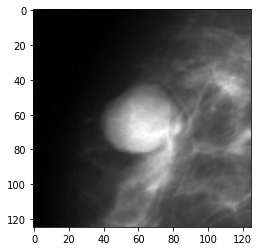

In [44]:
img_array = sitk.GetArrayFromImage(im_1)
import matplotlib.pyplot as plt

plt.imshow(img_array, cmap='gray')

# Calculating the values of active features

In [ ]:
print('Calculating features')
featureDict = extractor.execute(im_1,im_1_mask,label=255)
type(featureDict)

Features are stored in a dictionary

In [ ]:
featureDict

# Compute the features for the whole dataset and store them in a file 

We will compute the features for the whole dataset, and we will add to the dictionary the case IDs




In [32]:
import glob
import csv

In [35]:
images_fnames = glob.glob(os.path.join(dataset_path,'*_resized.pgm'))

In [36]:
extracted_data = []
for image_fname in images_fnames:
  mask_fname = image_fname.replace('resized', 'mass_mask')
  image = read_pgm_as_sitk(image_fname)
  mask = read_pgm_as_sitk(mask_fname)
  featureVector = extractor.execute(image, mask, label=255)
  featureVector['image_ID'] = os.path.basename(image_fname)
  featureVector['mask_ID'] = os.path.basename(mask_fname)
  extracted_data.append(featureVector)


In [ ]:
extracted_data

The extracted data is a list of dictionary

In [39]:
type(extracted_data)

list

We will identify the variables we will store in the .csv file. 

In [40]:
list(extracted_data[0].keys())

['diagnostics_Versions_PyRadiomics',
 'diagnostics_Versions_Numpy',
 'diagnostics_Versions_SimpleITK',
 'diagnostics_Versions_PyWavelet',
 'diagnostics_Versions_Python',
 'diagnostics_Configuration_Settings',
 'diagnostics_Configuration_EnabledImageTypes',
 'diagnostics_Image-original_Hash',
 'diagnostics_Image-original_Dimensionality',
 'diagnostics_Image-original_Spacing',
 'diagnostics_Image-original_Size',
 'diagnostics_Image-original_Mean',
 'diagnostics_Image-original_Minimum',
 'diagnostics_Image-original_Maximum',
 'diagnostics_Mask-original_Hash',
 'diagnostics_Mask-original_Spacing',
 'diagnostics_Mask-original_Size',
 'diagnostics_Mask-original_BoundingBox',
 'diagnostics_Mask-original_VoxelNum',
 'diagnostics_Mask-original_VolumeNum',
 'diagnostics_Mask-original_CenterOfMassIndex',
 'diagnostics_Mask-original_CenterOfMass',
 'original_firstorder_Mean',
 'original_firstorder_Skewness',
 'wavelet-LH_firstorder_Mean',
 'wavelet-LH_firstorder_Skewness',
 'wavelet-HL_firstorder_

We can either store them all: 

In [41]:
csv_columns =  list(extracted_data[0].keys())

or we can select a number of interesting features:

In [42]:
selected_features_name = [x for x in list(extracted_data[0].keys()) if 'firstorder' in x]
csv_columns = [ 'image_ID', 'mask_ID' ] + selected_features_name
csv_columns 


['image_ID',
 'mask_ID',
 'original_firstorder_Mean',
 'original_firstorder_Skewness',
 'wavelet-LH_firstorder_Mean',
 'wavelet-LH_firstorder_Skewness',
 'wavelet-HL_firstorder_Mean',
 'wavelet-HL_firstorder_Skewness',
 'wavelet-HH_firstorder_Mean',
 'wavelet-HH_firstorder_Skewness',
 'wavelet-LL_firstorder_Mean',
 'wavelet-LL_firstorder_Skewness']

We will store the selected features for further analysis in a .csv file

In [45]:
csv_file = "extracted_features.csv"

with open(csv_file, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns, extrasaction='ignore' )
    writer.writeheader()
    for data in extracted_data:
        writer.writerow(data)

In [46]:
!ls

drive			gdrive	  sample_data
extracted_features.csv	__MACOSX  small_sample_Im_segmented_ref


In [52]:
import pandas as pd
df = pd.read_csv('extracted_features.csv', sep=',') 
df

,image_ID,mask_ID,original_firstorder_Mean,original_firstorder_Skewness,wavelet-LH_firstorder_Mean,wavelet-LH_firstorder_Skewness,wavelet-HL_firstorder_Mean,wavelet-HL_firstorder_Skewness,wavelet-HH_firstorder_Mean,wavelet-HH_firstorder_Skewness,wavelet-LL_firstorder_Mean,wavelet-LL_firstorder_Skewness
0,0008p1_3_1_2_resized.pgm,0008p1_3_1_2_mass_mask.pgm,127.868695,-0.226103,-0.417037,0.008485,-0.409061,-0.694578,-0.000181,-0.099849,255.715845,-0.230803
1,0069p1_4_2_resized.pgm,0069p1_4_2_mass_mask.pgm,90.786982,-0.153444,-0.390353,-0.097369,-0.561163,0.066819,-0.002404,0.152356,181.485880,-0.195138
2,0025p1_4_1_resized.pgm,0025p1_4_1_mass_mask.pgm,204.362694,-0.241723,-0.750846,-0.034247,-0.967816,0.211509,0.014212,0.196231,408.672375,-0.226389
3,0197u1_4_2_resized.pgm,0197u1_4_2_mass_mask.pgm,85.942073,-0.055496,-0.141404,0.012399,-0.153354,-0.047822,0.006478,0.057096,171.795278,-0.045205
4,0036p1_1_1_resized.pgm,0036p1_1_1_mass_mask.pgm,180.682874,-0.231362,-0.571764,-0.156375,-0.453410,-0.094868,0.019553,0.034392,361.340790,-0.227224
5,0088b1_3_1_1_resized.pgm,0088b1_3_1_1_mass_mask.pgm,177.446134,-0.255500,-1.032466,-0.200928,-0.969070,-0.198718,-0.003268,-0.040249,354.850862,-0.256875
6,0016p1_2_1_resized.pgm,0016p1_2_1_mass_mask.pgm,191.465632,-0.609306,-0.757295,0.033237,-0.647626,0.766735,0.020392,-0.410479,382.815444,-0.589882
7,0037p1_2_2_resized.pgm,0037p1_2_2_mass_mask.pgm,93.341176,-0.995381,-0.610284,-0.046571,-0.898575,0.653780,0.013236,-0.246949,186.587161,-0.978492


We can copy the output file on our gdrive folder, as the /content/ forlder content will be reset after the session

In [ ]:
!cp extracted_features.csv /content/gdrive/My\ Drive/.